In [1]:
# !pip install yfinance
# !pip install TA-Lib 
# !pip install numpy
# !pip install pandas
# !pip install vectorbt
# !pip install scipy

In [2]:
import sys
print(sys.executable)


/Users/rodrigoburzacomolina/venvs/quant/bin/python


In [3]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import vectorbt as vbt
import warnings
from scipy import stats
import matplotlib.pyplot as plt


In [4]:
# DOWNLOAD STOCK DATA FROM 2018 USING YFINANCE

# Configuration - Change these variables as needed
TICKER = 'BTC-USD'  # Any ticker symbol (e.g., 'AAPL', 'MSFT', 'GOOGL')
START_DATE = '2018-01-01'  # Any start date in YYYY-MM-DD format

# Download data from start date onwards
stock_data = yf.download(TICKER, start=START_DATE, interval='1d')

if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER} from {START_DATE}")
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
    print("\nFirst 5 rows:")
    print(stock_data.head())
else:
    print(f"Failed to download {TICKER} data from yfinance")

# Display the downloaded data
stock_data


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2921 records for BTC-USD from 2018-01-01
Data range: 2018-01-01 to 2025-12-30

First 5 rows:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Ticker          BTC-USD  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2025-12-26,87301.429688,89459.429688,86628.140625,87235.507812,42455674908
2025-12-27,87802.156250,87874.781250,87182.976562,87301.429688,13741199310


In [5]:
# TECHNICAL ANALYSIS INDICATORS USING TA-LIB

# Make sure stock_data is available from the previous cell
if "stock_data" not in locals():
    raise ValueError("Please run the stock data download cell first")

# Extract OHLCV data (handling multi-level columns from yfinance)
if isinstance(stock_data.columns, pd.MultiIndex):
    close = stock_data[("Close", TICKER)].values
    high = stock_data[("High", TICKER)].values
    low = stock_data[("Low", TICKER)].values
    open_ = stock_data[("Open", TICKER)].values
    volume = stock_data[("Volume", TICKER)].values
else:
    close = stock_data["Close"].values
    high = stock_data["High"].values
    low = stock_data["Low"].values
    open_ = stock_data["Open"].values
    volume = stock_data["Volume"].values

print(f"Calculating technical indicators for {TICKER}...")

# Simple Moving Averages
sma_20 = talib.SMA(close, timeperiod=20)
sma_50 = talib.SMA(close, timeperiod=50)

# Exponential Moving Averages
ema_12 = talib.EMA(close, timeperiod=12)
ema_26 = talib.EMA(close, timeperiod=26)

# MACD
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

# RSI
rsi = talib.RSI(close, timeperiod=14)

# Stochastic RSI
stochrsi_k, stochrsi_d = talib.STOCHRSI(close, timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)

# VWAP (manual calculation)
typical_price = (high + low + close) / 3
price_volume = typical_price * volume
cumulative_price_volume = np.cumsum(price_volume)
cumulative_volume = np.cumsum(volume)
vwap = cumulative_price_volume / cumulative_volume

# Schaff Trend Cycle
cycle_period = 10
macd_cycle = talib.EMA(macd, timeperiod=cycle_period)
macd_smooth = talib.EMA(macd_cycle, timeperiod=cycle_period)
highest_macd = talib.MAX(macd_smooth, timeperiod=cycle_period)
lowest_macd = talib.MIN(macd_smooth, timeperiod=cycle_period)
stc_k = 100 * ((macd_smooth - lowest_macd) / (highest_macd - lowest_macd))
stc_d = talib.SMA(stc_k, timeperiod=3)

# Create indicators dataframe
indicators_df = pd.DataFrame({
    "Date": stock_data.index,
    "Close": close,
    "SMA_20": sma_20,
    "SMA_50": sma_50,
    "EMA_12": ema_12,
    "EMA_26": ema_26,
    "MACD": macd,
    "MACD_Signal": macdsignal,
    "MACD_Hist": macdhist,
    "RSI": rsi,
    "StochRSI_K": stochrsi_k,
    "StochRSI_D": stochrsi_d,
    "VWAP": vwap,
    "STC_K": stc_k,
    "STC_D": stc_d
})

print("All technical indicators calculated!")
print(f"Data shape: {indicators_df.shape}")
indicators_df.tail(5)

Calculating technical indicators for BTC-USD...
All technical indicators calculated!
Data shape: (2921, 15)


,Date,Close,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,StochRSI_K,StochRSI_D,VWAP,STC_K,STC_D
2916,2025-12-26,87301.429688,88800.272656,91442.518750,87933.014238,89246.483389,-1313.469151,-1490.742223,177.273071,42.642249,25.163033,16.617129,50816.519866,100.0,100.0
2917,2025-12-27,87802.156250,88670.098437,91131.113750,87912.882239,89139.496194,-1226.613954,-1437.916569,211.302615,44.616331,100.000000,41.721011,50822.256556,100.0,100.0
2918,2025-12-28,87835.835938,88529.880078,90842.188125,87901.028962,89042.928767,-1141.899805,-1378.713216,236.813411,44.754060,100.000000,75.054344,50828.602557,100.0,100.0
2919,2025-12-29,87138.140625,88252.201563,90490.558125,87783.661526,88901.833349,-1118.171823,-1326.604938,208.433114,42.401671,0.000000,66.666667,50849.029233,100.0,100.0
2920,2025-12-30,89112.617188,88106.785156,90152.878594,87988.116243,88917.446967,-929.330724,-1247.150095,317.819371,50.354593,100.000000,66.666667,50863.797193,100.0,100.0


In [6]:
# PREPARE PRICE SERIES

warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Expect stock_data and TICKER already exist
def select_close_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Close', ticker) in df.columns:
            s = df[('Close', ticker)]
        else:
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        s = df['Close']
    return s.astype(float).squeeze()

close = select_close_series(stock_data, TICKER)
close.name = 'price'

# Simple split
TRAIN_RATIO = 0.60 
split_idx = int(len(close) * TRAIN_RATIO)
train_close = close.iloc[:split_idx].copy()
val_close   = close.iloc[split_idx:].copy()

print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")

Data ready: train=2018-01-01 → 2022-10-18 | val=2022-10-19 → 2025-12-30


## TRIPLE EMA CROSSOVER GRID SEARCH - TRAINING SET
----------------------------------------------

This section performs a comprehensive grid search optimization for the **Triple EMA Crossover Strategy** using only the **training data**.

The goal is to find the optimal EMA1/EMA2/EMA3 combination that maximizes the Sharpe ratio on unseen data.

**Strategy Logic**: Buy when any EMA crosses above another (EMA1 > EMA2, EMA1 > EMA3, or EMA2 > EMA3). Sell when any EMA crosses below another.

---

In [7]:
# Define Parameter Ranges for Triple EMA Crossover

# EMA periods for triple crossover strategy
ema1_periods = list(range(4, 40, 3))    # Fast EMA (shortest-term)
ema2_periods = list(range(80, 200, 3))  # Medium EMA (can oscillate with EMA3)
ema3_periods = list(range(100, 200, 3)) # Slow EMA (can oscillate with EMA2)


# Periods is how many points it used to compute the EMA
print("EMA1 Periods (fast - shortest-term):")
for i, period in enumerate(ema1_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA2 Periods (medium - can oscillate with EMA3):")
for i, period in enumerate(ema2_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA3 Periods (slow - can oscillate with EMA2):")
for i, period in enumerate(ema3_periods, 1):
    print(f"  {i}. {period} periods")

# Generate all valid combinations (ema1 < ema2 AND ema1 < ema3, but ema2 and ema3 can be in any order)
# This allows for oscillation computation between ema2 and ema3
ema_combinations = []
for ema1 in ema1_periods:
    for ema2 in ema2_periods:
        for ema3 in ema3_periods:
            if ema1 < ema2 and ema1 < ema3:
                ema_combinations.append((ema1, ema2, ema3))

print(f"Generated {len(ema_combinations)} valid Triple EMA combinations")
print("Note: EMA2 and EMA3 can now oscillate (EMA2 can be > or < EMA3)")
print("\n First 10 combinations preview:")
for i, (ema1, ema2, ema3) in enumerate(ema_combinations[:10], 1):
    relationship = "EMA2 > EMA3" if ema2 > ema3 else ("EMA2 < EMA3" if ema2 < ema3 else "EMA2 = EMA3")
    print(f"  {i:2d}. EMA1: {ema1:2d} | EMA2: {ema2:2d} | EMA3: {ema3:2d} ({relationship})")
if len(ema_combinations) > 10:
    print(f"   ... and {len(ema_combinations) - 10} more combinations")

print("\nReady to test all combinations on training data!")

EMA1 Periods (fast - shortest-term):
  1. 4 periods
  2. 7 periods
  3. 10 periods
  4. 13 periods
  5. 16 periods
  6. 19 periods
  7. 22 periods
  8. 25 periods
  9. 28 periods
  10. 31 periods
  11. 34 periods
  12. 37 periods
EMA2 Periods (medium - can oscillate with EMA3):
  1. 80 periods
  2. 83 periods
  3. 86 periods
  4. 89 periods
  5. 92 periods
  6. 95 periods
  7. 98 periods
  8. 101 periods
  9. 104 periods
  10. 107 periods
  11. 110 periods
  12. 113 periods
  13. 116 periods
  14. 119 periods
  15. 122 periods
  16. 125 periods
  17. 128 periods
  18. 131 periods
  19. 134 periods
  20. 137 periods
  21. 140 periods
  22. 143 periods
  23. 146 periods
  24. 149 periods
  25. 152 periods
  26. 155 periods
  27. 158 periods
  28. 161 periods
  29. 164 periods
  30. 167 periods
  31. 170 periods
  32. 173 periods
  33. 176 periods
  34. 179 periods
  35. 182 periods
  36. 185 periods
  37. 188 periods
  38. 191 periods
  39. 194 periods
  40. 197 periods
EMA3 Periods (slo

In [8]:

# EMA periods for triple crossover strategy
ema1_periods = list(range(4, 40, 3))    # Fast EMA (shortest-term)
ema2_periods = list(range(80, 200, 3))  # Medium EMA (can oscillate with EMA3)


In [9]:
ema3_periods = list(range(100, 200, 3)) # Slow EMA (can oscillate with EMA2)



In [10]:

# Periods is how many points it used to compute the EMA
print("EMA1 Periods (fast - shortest-term):")
for i, period in enumerate(ema1_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA2 Periods (medium - can oscillate with EMA3):")
for i, period in enumerate(ema2_periods, 1):
    print(f"  {i}. {period} periods")

print("EMA3 Periods (slow - can oscillate with EMA2):")
for i, period in enumerate(ema3_periods, 1):
    print(f"  {i}. {period} periods")

# Generate all valid combinations (ema1 < ema2 AND ema1 < ema3, but ema2 and ema3 can be in any order)
# This allows for oscillation computation between ema2 and ema3
ema_combinations = []
for ema1 in ema1_periods:
    for ema2 in ema2_periods:
        for ema3 in ema3_periods:
            if ema1 < ema2 and ema1 < ema3:
                ema_combinations.append((ema1, ema2, ema3))

print(f"Generated {len(ema_combinations)} valid Triple EMA combinations")
print("Note: EMA2 and EMA3 can now oscillate (EMA2 can be > or < EMA3)")
print("\n First 10 combinations preview:")
for i, (ema1, ema2, ema3) in enumerate(ema_combinations[:10], 1):
    relationship = "EMA2 > EMA3" if ema2 > ema3 else ("EMA2 < EMA3" if ema2 < ema3 else "EMA2 = EMA3")
    print(f"  {i:2d}. EMA1: {ema1:2d} | EMA2: {ema2:2d} | EMA3: {ema3:2d} ({relationship})")
if len(ema_combinations) > 10:
    print(f"   ... and {len(ema_combinations) - 10} more combinations")

print("\nReady to test all combinations on training data!")

EMA1 Periods (fast - shortest-term):
  1. 4 periods
  2. 7 periods
  3. 10 periods
  4. 13 periods
  5. 16 periods
  6. 19 periods
  7. 22 periods
  8. 25 periods
  9. 28 periods
  10. 31 periods
  11. 34 periods
  12. 37 periods
EMA2 Periods (medium - can oscillate with EMA3):
  1. 80 periods
  2. 83 periods
  3. 86 periods
  4. 89 periods
  5. 92 periods
  6. 95 periods
  7. 98 periods
  8. 101 periods
  9. 104 periods
  10. 107 periods
  11. 110 periods
  12. 113 periods
  13. 116 periods
  14. 119 periods
  15. 122 periods
  16. 125 periods
  17. 128 periods
  18. 131 periods
  19. 134 periods
  20. 137 periods
  21. 140 periods
  22. 143 periods
  23. 146 periods
  24. 149 periods
  25. 152 periods
  26. 155 periods
  27. 158 periods
  28. 161 periods
  29. 164 periods
  30. 167 periods
  31. 170 periods
  32. 173 periods
  33. 176 periods
  34. 179 periods
  35. 182 periods
  36. 185 periods
  37. 188 periods
  38. 191 periods
  39. 194 periods
  40. 197 periods
EMA3 Periods (slo

In [11]:
# Initialize Triple EMA Results Collection System

# Create empty list to store all backtest results
grid_search_results = []

print("Triple EMA Results Collection System Initialized")
print(f"   - Will test {len(ema_combinations)} Triple EMA combinations")
print("   - Results will be stored in 'grid_search_results' list")

# Define what metrics we will collect (All TradingView-style metrics)
metrics_to_collect = [
    # Strategy Parameters
    "ema1_period",
    "ema2_period", 
    "ema3_period",
    
    # Return Metrics
    "total_return",
    "annualized_return",
    "total_profit",
    
    # Risk-Adjusted Return Metrics
    "sharpe_ratio",
    "sortino_ratio",
    "calmar_ratio",
    "omega_ratio",
    "information_ratio",
    "tail_ratio",
    "deflated_sharpe_ratio",
    
    # Risk Metrics
    "max_drawdown",
    "volatility",
    "ulcer_index",
    
    # Trade Performance Metrics
    "win_rate",
    "total_trades",
    "avg_trade_duration",
    "expectancy",
    "profit_factor", 
    "sqn",
    
    # Win/Loss Analysis
    "payoff_ratio",
    "largest_win",
    "largest_loss",
    "avg_win_amount",
    "avg_loss_amount",
    "winning_streak",
    "losing_streak",
    
    # Additional Ratios
    "recovery_factor",
    "gain_to_pain_ratio",
    "serenity_index"
]

print("Metrics to collect for each Triple EMA combination:")
for i, metric in enumerate(metrics_to_collect, 1):
    print(f"  {i}. {metric.replace('_', ' ').title()}")

print("Ready to start the Triple EMA grid search!")


Triple EMA Results Collection System Initialized
   - Will test 16320 Triple EMA combinations
   - Results will be stored in 'grid_search_results' list
Metrics to collect for each Triple EMA combination:
  1. Ema1 Period
  2. Ema2 Period
  3. Ema3 Period
  4. Total Return
  5. Annualized Return
  6. Total Profit
  7. Sharpe Ratio
  8. Sortino Ratio
  9. Calmar Ratio
  10. Omega Ratio
  11. Information Ratio
  12. Tail Ratio
  13. Deflated Sharpe Ratio
  14. Max Drawdown
  15. Volatility
  16. Ulcer Index
  17. Win Rate
  18. Total Trades
  19. Avg Trade Duration
  20. Expectancy
  21. Profit Factor
  22. Sqn
  23. Payoff Ratio
  24. Largest Win
  25. Largest Loss
  26. Avg Win Amount
  27. Avg Loss Amount
  28. Winning Streak
  29. Losing Streak
  30. Recovery Factor
  31. Gain To Pain Ratio
  32. Serenity Index
Ready to start the Triple EMA grid search!


In [12]:
# VISUALIZE SIGNALS FOR ONE EXAMPLE

example_ema1, example_ema2, example_ema3 = 7, 93, 152
ema1_ma = vbt.MA.run(train_close, example_ema1, ewm=True).ma
ema2_ma = vbt.MA.run(train_close, example_ema2, ewm=True).ma
ema3_ma = vbt.MA.run(train_close, example_ema3, ewm=True).ma

# Triple EMA crossover signals
entries_1 = ema1_ma.vbt.crossed_above(ema2_ma).reindex(train_close.index).fillna(False)
entries_2 = ema1_ma.vbt.crossed_above(ema3_ma).reindex(train_close.index).fillna(False)
entries_3 = ema2_ma.vbt.crossed_above(ema3_ma).reindex(train_close.index).fillna(False)
entries = entries_1 | entries_2 | entries_3

exits_1 = ema1_ma.vbt.crossed_below(ema2_ma).reindex(train_close.index).fillna(False)
exits_2 = ema1_ma.vbt.crossed_below(ema3_ma).reindex(train_close.index).fillna(False)
exits_3 = ema2_ma.vbt.crossed_below(ema3_ma).reindex(train_close.index).fillna(False)
exits = exits_1 | exits_2 | exits_3

signals_df = pd.DataFrame({
    'Close': train_close.values,
    'EMA1': ema1_ma.values,
    'EMA2': ema2_ma.values,
    'EMA3': ema3_ma.values,
    'Buy': entries.values.astype(bool),
    'Sell': exits.values.astype(bool)
}, index=train_close.index)
signals_df.index.name = 'Date'

pos = 0
pos_list = []
for buy, sell in zip(signals_df['Buy'], signals_df['Sell']):
    if buy: pos = 1
    elif sell: pos = 0
    pos_list.append(pos)
signals_df['Position'] = pos_list

print(f"Example EMA({example_ema1},{example_ema2},{example_ema3}) signals:")
print(signals_df.head(500).to_string())


Example EMA(7,93,152) signals:
                   Close          EMA1          EMA2         EMA3    Buy   Sell  Position
Date                                                                                     
2018-01-01  13657.200195           NaN           NaN          NaN  False  False         0
2018-01-02  14982.099609           NaN           NaN          NaN  False  False         0
2018-01-03  15201.000000           NaN           NaN          NaN  False  False         0
2018-01-04  15599.200195           NaN           NaN          NaN  False  False         0
2018-01-05  17429.500000           NaN           NaN          NaN  False  False         0
2018-01-06  17527.000000           NaN           NaN          NaN  False  False         0
2018-01-07  16477.599609  16023.905672           NaN          NaN  False  False         0
2018-01-08  15170.099609  15810.454156           NaN          NaN  False  False         0
2018-01-09  14595.400391  15506.690715           NaN          NaN  Fa

In [13]:
# TRIPLE EMA CROSSOVER GRID SEARCH ON TRAINING DATA - VECTORIZED & BATCHED

print("INITIATING VECTORIZED TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION")
print("=" * 70)
print(f"Testing Strategy: Triple Exponential Moving Average Crossover")
print(f"Training Period: {train_close.index[0].date()} → {train_close.index[-1].date()}")
print(f"Initial Capital: $100,000")
print(f"Transaction Costs: 0.05% per trade (fees + slippage)")
print(f"Optimization Metric: Sharpe Ratio (risk-adjusted returns)")
print("=" * 70)

# Configuration
BATCH_SIZE = 1000  # Process combinations in batches to manage memory
total_combinations = len(ema_combinations)

print(f"Total combinations to test: {total_combinations}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Using vectorized computation for maximum speed\n")

# Calculate all unique EMA periods needed
all_ema_periods = sorted(list(set([p for combo in ema_combinations for p in combo])))
print(f"Pre-computing {len(all_ema_periods)} unique EMAs: {all_ema_periods}")

# Pre-compute ALL EMAs at once (vectorized)
print("Computing all EMAs in vectorized mode...")
ema_cache = vbt.MA.run(train_close, window=all_ema_periods, ewm=True)
print("✓ All EMAs computed\n")

# Process in batches
grid_search_results = []
successful_tests = 0
failed_tests = 0

print("Starting batched grid search...\n")

for batch_start in range(0, total_combinations, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, total_combinations)
    batch_combos = ema_combinations[batch_start:batch_end]
    batch_size = len(batch_combos)
    
    print(f"Processing batch {batch_start//BATCH_SIZE + 1}/{(total_combinations + BATCH_SIZE - 1)//BATCH_SIZE}")
    print(f"  Combinations {batch_start+1} to {batch_end}...")
    
    # Build signal matrices for this batch
    batch_entries = []
    batch_exits = []
    
    for ema1_period, ema2_period, ema3_period in batch_combos:
        try:
            # Get pre-computed EMAs from cache and ensure 1D
            ema1 = pd.Series(ema_cache.ma[ema1_period].values.flatten(), index=train_close.index)
            ema2 = pd.Series(ema_cache.ma[ema2_period].values.flatten(), index=train_close.index)
            ema3 = pd.Series(ema_cache.ma[ema3_period].values.flatten(), index=train_close.index)
            
            # Triple EMA crossover signals
            entries_raw = (
                ema1.vbt.crossed_above(ema2) |
                ema1.vbt.crossed_above(ema3) |
                ema2.vbt.crossed_above(ema3)
            )
            exits_raw = (
                ema1.vbt.crossed_below(ema2) |
                ema1.vbt.crossed_below(ema3) |
                ema2.vbt.crossed_below(ema3)
            )
            
            # Fix lookahead bias: shift signals by 1 bar (clean, no warnings)
            entries_shifted = entries_raw.shift(1)
            entries = pd.Series(np.where(entries_shifted.isna(), False, entries_shifted), index=train_close.index, dtype=bool)
            
            exits_shifted = exits_raw.shift(1)
            exits = pd.Series(np.where(exits_shifted.isna(), False, exits_shifted), index=train_close.index, dtype=bool)
            
            batch_entries.append(entries)
            batch_exits.append(exits)
            
        except Exception as e:
            # Add empty signals for failed combinations
            batch_entries.append(pd.Series(False, index=train_close.index, dtype=bool))
            batch_exits.append(pd.Series(False, index=train_close.index, dtype=bool))
            failed_tests += 1
    
    # Convert to DataFrame for vectorized backtesting
    entries_df = pd.DataFrame(batch_entries).T
    exits_df = pd.DataFrame(batch_exits).T
    
    # Vectorized backtest for entire batch at once
    print(f"  Running vectorized backtest on {batch_size} combinations...")
    try:
        portfolios = vbt.Portfolio.from_signals(
            close=train_close,
            entries=entries_df,
            exits=exits_df,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq='D'
        )
        
        # Extract metrics for all combinations in batch
        total_returns = portfolios.total_return()
        annualized_returns = portfolios.annualized_return(freq='D')
        max_drawdowns = portfolios.max_drawdown()
        volatilities = portfolios.annualized_volatility(freq='D')
        sharpe_ratios = portfolios.sharpe_ratio(freq='D')
        sortino_ratios = portfolios.sortino_ratio(freq='D')
        
        # Process each result in the batch
        for idx, (ema1_period, ema2_period, ema3_period) in enumerate(batch_combos):
            try:
                # Get scalar values for this combination
                total_return = float(total_returns.iloc[idx] if hasattr(total_returns, 'iloc') else total_returns)
                annualized_return = float(annualized_returns.iloc[idx] if hasattr(annualized_returns, 'iloc') else annualized_returns)
                max_drawdown = float(max_drawdowns.iloc[idx] if hasattr(max_drawdowns, 'iloc') else max_drawdowns)
                volatility = float(volatilities.iloc[idx] if hasattr(volatilities, 'iloc') else volatilities)
                sharpe_ratio = float(sharpe_ratios.iloc[idx] if hasattr(sharpe_ratios, 'iloc') else sharpe_ratios)
                sortino_ratio = float(sortino_ratios.iloc[idx] if hasattr(sortino_ratios, 'iloc') else sortino_ratios)
                
                # Get trade-level metrics
                trades = portfolios.trades if batch_size == 1 else portfolios[idx].trades
                total_trades = len(trades)
                
                # Trades per year filter
                years = max((train_close.index[-1] - train_close.index[0]).days / 365.25, 1e-9)
                trades_per_year = total_trades / years
                
                if trades_per_year < 2:
                    continue
                
                # Trade statistics
                win_rate_pct = np.nan
                profit_factor = np.nan
                expectancy = 0.0
                avg_win_amount = 0.0
                avg_loss_amount = 0.0
                winning_streak = np.nan
                losing_streak = np.nan
                
                if total_trades > 0:
                    tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
                    if tr.size > 0:
                        pos = tr[tr > 0]
                        neg = tr[tr < 0]
                        win_rate_pct = (len(pos) / len(tr)) * 100.0 if len(tr) > 0 else np.nan
                        gains = pos.sum() if len(pos) else 0.0
                        losses = abs(neg.sum()) if len(neg) else 0.0
                        profit_factor = gains / losses if losses > 0 else np.inf
                        expectancy = float(tr.mean())
                        avg_win_amount = float(pos.mean()) if len(pos) else 0.0
                        avg_loss_amount = float(abs(neg.mean())) if len(neg) else 0.0
                        
                        try:
                            winning_streak = int(trades.winning_streak[idx] if batch_size > 1 else trades.winning_streak())
                            losing_streak = int(trades.losing_streak[idx] if batch_size > 1 else trades.losing_streak())
                        except:
                            pass
                
                # Ulcer Index
                returns = portfolios.returns().iloc[:, idx] if batch_size > 1 else portfolios.returns()
                cum = (1 + returns).cumprod()
                peak = cum.cummax()
                dd = (cum - peak) / peak
                ulcer_index = float(np.sqrt((dd.pow(2)).mean())) if len(dd) > 0 else np.nan
                
                payoff_ratio = (avg_win_amount / avg_loss_amount) if avg_loss_amount not in (0.0, np.nan) else np.inf
                
                # Store results
                grid_search_results.append({
                    "ema1_period": ema1_period,
                    "ema2_period": ema2_period,
                    "ema3_period": ema3_period,
                    "total_return": total_return,
                    "annualized_return": annualized_return,
                    "max_drawdown": max_drawdown,
                    "volatility": volatility,
                    "sharpe_ratio": sharpe_ratio,
                    "sortino_ratio": sortino_ratio,
                    "information_ratio": np.nan,
                    "tail_ratio": np.nan,
                    "deflated_sharpe_ratio": np.nan,
                    "ulcer_index": ulcer_index,
                    "total_trades": total_trades,
                    "win_rate": win_rate_pct,
                    "profit_factor": profit_factor,
                    "expectancy": expectancy,
                    "avg_win_amount": avg_win_amount,
                    "avg_loss_amount": avg_loss_amount,
                    "payoff_ratio": payoff_ratio,
                    "winning_streak": winning_streak,
                    "losing_streak": losing_streak,
                    "trades_per_year": trades_per_year
                })
                successful_tests += 1
                
            except Exception as e:
                failed_tests += 1
                
    except Exception as e:
        print(f"  ⚠️ Batch failed: {str(e)[:100]}")
        failed_tests += batch_size
    
    # Progress update
    progress_pct = (batch_end / total_combinations) * 100
    print(f"  ✓ Batch complete: {successful_tests} successful, {failed_tests} failed")
    print(f"  Overall progress: {batch_end}/{total_combinations} ({progress_pct:.1f}%)\n")

# SUMMARY
print("=" * 70)
print("VECTORIZED GRID SEARCH COMPLETED!")
print("=" * 70)
print(f"Total combinations attempted: {total_combinations}")
print(f"Successfully completed: {successful_tests}")
print(f"Failed: {failed_tests}")
print(f"Success rate: {(successful_tests/total_combinations)*100:.1f}%")
print(f"\n✓ Results stored in 'grid_search_results' ({len(grid_search_results)} entries)")

if successful_tests > 0:
    results_df_preview = pd.DataFrame(grid_search_results)
    
    # Display top 5 combinations
    print("\n" + "=" * 70)
    print("🏆 TOP 5 COMBINATIONS (by In-Sample Sharpe Ratio)")
    print("=" * 70)
    
    top_5 = results_df_preview.nlargest(5, 'sharpe_ratio')
    for rank, (idx, row) in enumerate(top_5.iterrows(), 1):
        print(f"\n#{rank} - EMA({int(row['ema1_period'])}, {int(row['ema2_period'])}, {int(row['ema3_period'])})")
        print(f"   Sharpe Ratio:      {row['sharpe_ratio']:.3f}")
        print(f"   Total Return:      {row['total_return']:.2%}")
        print(f"   Annualized Return: {row['annualized_return']:.2%}")
        print(f"   Max Drawdown:      {row['max_drawdown']:.2%}")
        print(f"   Win Rate:          {row['win_rate']:.1f}%")
        print(f"   Profit Factor:     {row['profit_factor']:.2f}")
        print(f"   Total Trades:      {int(row['total_trades'])} ({row['trades_per_year']:.1f}/year)")
    
    print("\n" + "=" * 70)

INITIATING VECTORIZED TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION
Testing Strategy: Triple Exponential Moving Average Crossover
Training Period: 2018-01-01 → 2022-10-18
Initial Capital: $100,000
Transaction Costs: 0.05% per trade (fees + slippage)
Optimization Metric: Sharpe Ratio (risk-adjusted returns)
Total combinations to test: 16320
Batch size: 1000
Using vectorized computation for maximum speed

Pre-computing 86 unique EMAs: [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 80, 83, 86, 89, 92, 95, 98, 100, 101, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 154, 155, 157, 158, 160, 161, 163, 164, 166, 167, 169, 170, 172, 173, 175, 176, 178, 179, 181, 182, 184, 185, 187, 188, 190, 191, 193, 194, 196, 197, 199]
Computing all EMAs in vectorized mode...
✓ All EMAs computed

Starting batched grid search...

Processing batch 1/17
  Combinations 1 to 1000...
  Runnin

In [14]:
# Analyze Triple EMA Grid Search Results

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search_results)

print("Grid Search Results Analysis")
print("=" * 50)
print(f"Total combinations tested: {len(results_df)}")
print(f"Results shape: {results_df.shape}")

# Comprehensive TradingView-style statistics
print("Comprehensive Performance Statistics:")
print("-" * 50)

# Return Metrics
print("Return Metrics:")
print(f"   Best Total Return: {results_df['total_return'].max():.2%}")
print(f"   Average Total Return: {results_df['total_return'].mean():.2%}")
print(f"   Best Annualized Return: {results_df['annualized_return'].max():.2%}")

# Risk-Adjusted Metrics
print("Risk-Adjusted Return Metrics:")
print(f"   Best Sharpe Ratio: {results_df['sharpe_ratio'].max():.3f}")
print(f"   Best Sortino Ratio: {results_df['sortino_ratio'].max():.3f}")

# Risk Metrics
print("Risk Metrics:")
print(f"   Average Max Drawdown: {results_df['max_drawdown'].mean():.2%}")
print(f"   Best Max Drawdown: {results_df['max_drawdown'].min():.2%}")
print(f"   Average Volatility: {results_df['volatility'].mean():.2%}")

# Trade Performance
print("Trade Performance:")
print(f"   Best Win Rate: {results_df['win_rate'].max():.1f}%")  # Changed from :.1%
print(f"   Average Win Rate: {results_df['win_rate'].mean():.1f}%")  # Changed from :.1%
print(f"   Best Profit Factor: {results_df['profit_factor'].max():.2f}")
print(f"   Total Trades Range: {results_df['total_trades'].min():.0f} - {results_df['total_trades'].max():.0f}")

# Additional Available Metrics
print("Additional Metrics:")
print(f"   Best Expectancy: {results_df['expectancy'].max():.4f}")
print(f"   Average Trades per Year: {results_df['trades_per_year'].mean():.1f}")

# Find best combination by Sharpe ratio
best_result = results_df.loc[results_df['sharpe_ratio'].idxmax()]

print("BEST STRATEGY (by Sharpe Ratio)")
print("-" * 50)
print(f"EMA1 Period (Fast): {int(best_result['ema1_period'])}")
print(f"EMA2 Period (Medium): {int(best_result['ema2_period'])}")
print(f"EMA3 Period (Slow): {int(best_result['ema3_period'])}")
print(f"Total Return: {best_result['total_return']:.2%}")
print(f"Sharpe Ratio: {best_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {best_result['max_drawdown']:.2%}")
print(f"Win Rate: {best_result['win_rate']:.1f}%")  # Changed from :.1%
print(f"Total Trades: {int(best_result['total_trades'])}")

print("Top 5 Best Performers:")
top_5 = results_df.nlargest(5, "sharpe_ratio")
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. EMA({int(row['ema1_period'])},{int(row['ema2_period'])},{int(row['ema3_period'])}) → Sharpe: {row['sharpe_ratio']:.3f}, Return: {row['total_return']:.1%}")

print("nAnalysis complete! Best strategy identified.")

Grid Search Results Analysis
Total combinations tested: 1891
Results shape: (1891, 23)
Comprehensive Performance Statistics:
--------------------------------------------------
Return Metrics:
   Best Total Return: 2221.50%
   Average Total Return: 574.19%
   Best Annualized Return: 92.55%
Risk-Adjusted Return Metrics:
   Best Sharpe Ratio: 1.754
   Best Sortino Ratio: 3.107
Risk Metrics:
   Average Max Drawdown: -40.97%
   Best Max Drawdown: -53.05%
   Average Volatility: 42.52%
Trade Performance:
   Best Win Rate: 75.0%
   Average Win Rate: 49.2%
   Best Profit Factor: 27.05
   Total Trades Range: 10 - 22
Additional Metrics:
   Best Expectancy: 0.4976
   Average Trades per Year: 2.6
BEST STRATEGY (by Sharpe Ratio)
--------------------------------------------------
EMA1 Period (Fast): 4
EMA2 Period (Medium): 149
EMA3 Period (Slow): 106
Total Return: 2197.04%
Sharpe Ratio: 1.754
Max Drawdown: -36.44%
Win Rate: 57.1%
Total Trades: 14
Top 5 Best Performers:
1. EMA(4,149,106) → Sharpe: 1.7

In [15]:
# TOP 5 OUT-OF-SAMPLE VALIDATION & COMPARISON TABLE

if 'FREQ' not in globals():
    FREQ = "1D"

if results_df.empty:
    print("No results to validate.")
else:
    print("=" * 90)
    print("🏆 TOP 5 STRATEGIES - OUT-OF-SAMPLE VALIDATION")
    print("=" * 90)
    print(f"Training Period: {train_close.index[0].date()} → {train_close.index[-1].date()}")
    print(f"Validation Period: {val_close.index[0].date()} → {val_close.index[-1].date()}")
    print("=" * 90)
    
    # Get top 5 by in-sample Sharpe
    top_5_strategies = results_df.nlargest(5, 'sharpe_ratio')
    
    # Results storage
    oos_results = []
    
    for idx, strategy in top_5_strategies.iterrows():
        ema1 = int(strategy['ema1_period'])
        ema2 = int(strategy['ema2_period'])
        ema3 = int(strategy['ema3_period'])
        
        # Compute EMAs on validation data
        ema1_val = pd.Series(vbt.MA.run(val_close, ema1, ewm=True).ma.values.flatten(), index=val_close.index)
        ema2_val = pd.Series(vbt.MA.run(val_close, ema2, ewm=True).ma.values.flatten(), index=val_close.index)
        ema3_val = pd.Series(vbt.MA.run(val_close, ema3, ewm=True).ma.values.flatten(), index=val_close.index)
        
        # Triple EMA crossover signals
        entries_raw = (
            ema1_val.vbt.crossed_above(ema2_val) |
            ema1_val.vbt.crossed_above(ema3_val) |
            ema2_val.vbt.crossed_above(ema3_val)
        )
        exits_raw = (
            ema1_val.vbt.crossed_below(ema2_val) |
            ema1_val.vbt.crossed_below(ema3_val) |
            ema2_val.vbt.crossed_below(ema3_val)
        )
        
        # Fix lookahead bias: shift signals by 1 bar
        entries_shifted = entries_raw.shift(1)
        entries = pd.Series(np.where(entries_shifted.isna(), False, entries_shifted), index=val_close.index, dtype=bool)
        
        exits_shifted = exits_raw.shift(1)
        exits = pd.Series(np.where(exits_shifted.isna(), False, exits_shifted), index=val_close.index, dtype=bool)
        
        # Run OOS backtest
        pf_val = vbt.Portfolio.from_signals(
            close=val_close,
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq=FREQ
        )
        
        # OOS metrics
        oos_total_return = float(pf_val.total_return())
        oos_annualized_return = float(pf_val.annualized_return(freq=FREQ))
        oos_sharpe = float(pf_val.sharpe_ratio(freq=FREQ))
        oos_sortino = float(pf_val.sortino_ratio(freq=FREQ))
        oos_max_drawdown = float(pf_val.max_drawdown())
        oos_volatility = float(pf_val.annualized_volatility(freq=FREQ))
        
        trades = pf_val.trades
        oos_total_trades = len(trades)
        years = max((val_close.index[-1] - val_close.index[0]).days / 365.25, 1e-9)
        oos_trades_per_year = oos_total_trades / years
        
        oos_win_rate_pct = np.nan
        oos_profit_factor = np.nan
        oos_expectancy = 0.0
        
        if oos_total_trades > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                oos_win_rate_pct = (len(pos) / len(tr)) * 100.0 if len(tr) > 0 else np.nan
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                oos_profit_factor = gains / losses if losses > 0 else np.inf
                oos_expectancy = float(tr.mean())
        
        # Store results
        oos_results.append({
            'Rank': len(oos_results) + 1,
            'EMA1': ema1,
            'EMA2': ema2,
            'EMA3': ema3,
            'IS_Sharpe': float(strategy['sharpe_ratio']),
            'IS_Return': float(strategy['total_return']),
            'IS_MaxDD': float(strategy['max_drawdown']),
            'IS_WinRate': float(strategy['win_rate']),
            'OOS_Sharpe': oos_sharpe,
            'OOS_Return': oos_total_return,
            'OOS_MaxDD': oos_max_drawdown,
            'OOS_WinRate': oos_win_rate_pct,
            'OOS_Trades': oos_total_trades,
            'OOS_ProfitFactor': oos_profit_factor,
            'Sharpe_Degradation': ((oos_sharpe - strategy['sharpe_ratio']) / abs(strategy['sharpe_ratio']) * 100) if strategy['sharpe_ratio'] != 0 else np.nan,
            'Return_Degradation': ((oos_total_return - strategy['total_return']) / abs(strategy['total_return']) * 100) if strategy['total_return'] != 0 else np.nan
        })
    
    # Create DataFrame
    oos_df = pd.DataFrame(oos_results)
    
    # Sort by OOS Sharpe (best to worst)
    oos_df_sorted = oos_df.sort_values('OOS_Sharpe', ascending=False).reset_index(drop=True)
    oos_df_sorted['OOS_Rank'] = range(1, len(oos_df_sorted) + 1)
    
    # Display comprehensive table
    print("\n📊 COMPREHENSIVE COMPARISON TABLE (Sorted by OOS Sharpe)")
    print("=" * 90)
    
    display_df = pd.DataFrame({
        'IS→OOS Rank': oos_df_sorted['Rank'].astype(str) + '→' + oos_df_sorted['OOS_Rank'].astype(str),
        'Strategy': oos_df_sorted.apply(lambda x: f"EMA({x['EMA1']},{x['EMA2']},{x['EMA3']})", axis=1),
        'IS Sharpe': oos_df_sorted['IS_Sharpe'].map('{:.3f}'.format),
        'OOS Sharpe': oos_df_sorted['OOS_Sharpe'].map('{:.3f}'.format),
        'Sharpe Δ%': oos_df_sorted['Sharpe_Degradation'].map('{:+.1f}%'.format),
        'IS Return': oos_df_sorted['IS_Return'].map('{:.1%}'.format),
        'OOS Return': oos_df_sorted['OOS_Return'].map('{:.1%}'.format),
        'Return Δ%': oos_df_sorted['Return_Degradation'].map('{:+.1f}%'.format),
        'OOS Trades': oos_df_sorted['OOS_Trades'].astype(int),
        'OOS WinRate': oos_df_sorted['OOS_WinRate'].map('{:.1f}%'.format),
        'OOS PF': oos_df_sorted['OOS_ProfitFactor'].map('{:.2f}'.format)
    })
    
    print(display_df.to_string(index=False))
    
    # Highlight best OOS performer
    best_oos = oos_df_sorted.iloc[0]
    print("\n" + "=" * 90)
    print(f"✨ BEST OUT-OF-SAMPLE PERFORMER")
    print("=" * 90)
    print(f"Strategy: EMA({int(best_oos['EMA1'])}, {int(best_oos['EMA2'])}, {int(best_oos['EMA3'])})")
    print(f"In-Sample Rank:        #{int(best_oos['Rank'])}")
    print(f"Out-of-Sample Rank:    #1")
    print(f"OOS Sharpe Ratio:      {best_oos['OOS_Sharpe']:.3f}")
    print(f"OOS Return:            {best_oos['OOS_Return']:.2%}")
    print(f"OOS Max Drawdown:      {best_oos['OOS_MaxDD']:.2%}")
    print(f"OOS Win Rate:          {best_oos['OOS_WinRate']:.1f}%")
    print(f"OOS Profit Factor:     {best_oos['OOS_ProfitFactor']:.2f}")
    print(f"OOS Total Trades:      {int(best_oos['OOS_Trades'])}")
    print(f"Sharpe Degradation:    {best_oos['Sharpe_Degradation']:+.1f}%")
    print("=" * 90)


🏆 TOP 5 STRATEGIES - OUT-OF-SAMPLE VALIDATION
Training Period: 2018-01-01 → 2022-10-18
Validation Period: 2022-10-19 → 2025-12-30

📊 COMPREHENSIVE COMPARISON TABLE (Sorted by OOS Sharpe)
IS→OOS Rank             Strategy IS Sharpe OOS Sharpe Sharpe Δ% IS Return OOS Return Return Δ%  OOS Trades OOS WinRate OOS PF
        2→1 EMA(4.0,152.0,106.0)     1.751      0.897    -48.8%   2188.8%     132.6%    -93.9%          15       40.0%   3.95
        5→2 EMA(4.0,173.0,106.0)     1.744      0.824    -52.8%   2166.0%     114.1%    -94.7%          14       28.6%   3.51
        3→3 EMA(4.0,161.0,106.0)     1.748      0.812    -53.6%   2221.5%     110.8%    -95.0%          16       37.5%   3.32
        1→4 EMA(4.0,149.0,106.0)     1.754      0.806    -54.0%   2197.0%     109.4%    -95.0%          14       35.7%   3.27
        4→5 EMA(4.0,164.0,103.0)     1.747      0.783    -55.2%   2217.5%     103.5%    -95.3%          17       41.2%   3.15

✨ BEST OUT-OF-SAMPLE PERFORMER
Strategy: EMA(4, 152, 106

In [16]:
# FULL-SAMPLE EVALUATION 

if 'FREQ' not in globals():
    FREQ = "1D"

# 1) Select full Close series from stock_data (robust to MultiIndex)
if isinstance(stock_data.columns, pd.MultiIndex):
    if ('Close', TICKER) in stock_data.columns:
        full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
    else:
        # fallbacks
        found = None
        for col in stock_data.columns:
            if isinstance(col, tuple) and ('Close' in col):
                found = col
                break
        if found is None:
            for col in stock_data.columns:
                if 'Close' in str(col):
                    found = col
                    break
        if found is None:
            raise KeyError("Could not find a 'Close' column for full-sample test.")
        full_close = stock_data[found].astype(float).rename(TICKER)
else:
    full_close = stock_data['Close'].astype(float).rename(TICKER)

# 2) Use best parameters from training results
if 'results_df' not in globals() or results_df.empty:
    raise ValueError("results_df is empty or missing. Run the grid search first.")
best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

print(f"FULL-SAMPLE EVALUATION: EMA({ema1},{ema2},{ema3}) on {full_close.index[0].date()} → {full_close.index[-1].date()}")

# 3) Recompute indicators on the full sample
ema1_full = vbt.MA.run(full_close, ema1, ewm=True).ma
ema2_full = vbt.MA.run(full_close, ema2, ewm=True).ma
ema3_full = vbt.MA.run(full_close, ema3, ewm=True).ma

# 4) Generate signals (convert to plain arrays to avoid ColumnsOnly errors)
e1 = ema1_full.vbt.crossed_above(ema2_full).reindex(full_close.index).fillna(False)
e2 = ema1_full.vbt.crossed_above(ema3_full).reindex(full_close.index).fillna(False)
e3 = ema2_full.vbt.crossed_above(ema3_full).reindex(full_close.index).fillna(False)
entries_raw = e1 | e2 | e3

x1 = ema1_full.vbt.crossed_below(ema2_full).reindex(full_close.index).fillna(False)
x2 = ema1_full.vbt.crossed_below(ema3_full).reindex(full_close.index).fillna(False)
x3 = ema2_full.vbt.crossed_below(ema3_full).reindex(full_close.index).fillna(False)
exits_raw = x1 | x2 | x3

# ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
entries = entries_raw.shift(1).fillna(False).to_numpy(dtype=bool)
exits = exits_raw.shift(1).fillna(False).to_numpy(dtype=bool)

# 5) Full-sample backtest
pf_full = vbt.Portfolio.from_signals(
    close=full_close.to_numpy(dtype=float),
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq=FREQ
)

# 6) Metrics
full_total_return = pf_full.total_return()
full_annualized_return = pf_full.annualized_return(freq=FREQ)
full_sharpe = pf_full.sharpe_ratio(freq=FREQ)
full_sortino = pf_full.sortino_ratio(freq=FREQ)
full_max_dd = pf_full.max_drawdown()
full_vol = pf_full.annualized_volatility(freq=FREQ)

# Trade metrics (compute explicitly for correctness)
trades = pf_full.trades
full_total_trades = len(trades)
years = max((full_close.index[-1] - full_close.index[0]).days / 365.25, 1e-9)
full_trades_per_year = full_total_trades / years

full_win_rate_pct = np.nan
full_profit_factor = np.nan
full_expectancy = 0.0
avg_win_amount = 0.0
avg_loss_amount = 0.0

if full_total_trades > 0:
    tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
    if tr.size > 0:
        pos = tr[tr > 0]
        neg = tr[tr < 0]
        full_win_rate_pct = (len(pos) / len(tr)) * 100.0
        gains = pos.sum() if len(pos) else 0.0
        losses = abs(neg.sum()) if len(neg) else 0.0
        full_profit_factor = (gains / losses) if losses > 0 else np.inf
        full_expectancy = tr.mean()
        avg_win_amount = float(pos.mean()) if len(pos) else 0.0
        avg_loss_amount = float(abs(neg.mean())) if len(neg) else 0.0

# 7) Optional benchmark
bh_total_return = (full_close.iloc[-1] / full_close.iloc[0]) - 1.0
bh_annualized = (1.0 + bh_total_return) ** (1.0 / years) - 1.0 if years > 0 else np.nan

# 8) Display

print("FULL-SAMPLE RESULTS")

print("RETURN METRICS:")
print(f"{'Total Return':<25} {full_total_return:>10.2%}")
print(f"{'Annualized Return':<25} {full_annualized_return:>10.2%}")

print("RISK-ADJUSTED:")
print(f"{'Sharpe Ratio':<25} {full_sharpe:>10.3f}")
print(f"{'Sortino Ratio':<25} {full_sortino:>10.3f}")

print("RISK:")
print(f"{'Max Drawdown':<25} {full_max_dd:>10.2%}")
print(f"{'Volatility':<25} {full_vol:>10.2%}")

print("TRADES:")
print(f"{'Total Trades':<25} {full_total_trades:>10.0f}")
print(f"{'Trades per Year':<25} {full_trades_per_year:>10.1f}")
print(f"{'Win Rate %':<25} {full_win_rate_pct if not np.isnan(full_win_rate_pct) else np.nan:>10.1f}")
print(f"{'Profit Factor':<25} {full_profit_factor:>10.2f}")
print(f"{'Expectancy':<25} {full_expectancy:>10.4f}")
print(f"{'Avg Win Amount':<25} {avg_win_amount:>10.4f}")
print(f"{'Avg Loss Amount':<25} {avg_loss_amount:>10.4f}")

print("BENCHMARK (BUY & HOLD):")
print(f"{'Total Return':<25} {bh_total_return:>10.2%}")
print(f"{'Annualized Return':<25} {bh_annualized:>10.2%}")

FULL-SAMPLE EVALUATION: EMA(4,149,106) on 2018-01-01 → 2025-12-30
FULL-SAMPLE RESULTS
RETURN METRICS:
Total Return                5369.03%
Annualized Return             64.88%
RISK-ADJUSTED:
Sharpe Ratio                   1.427
Sortino Ratio                  2.414
RISK:
Max Drawdown                 -40.77%
Volatility                    40.80%
TRADES:
Total Trades                      29
Trades per Year                  3.6
Win Rate %                      48.3
Profit Factor                   9.79
Expectancy                    0.2407
Avg Win Amount                0.5553
Avg Loss Amount               0.0529
BENCHMARK (BUY & HOLD):
Total Return                 552.50%
Annualized Return             26.44%


/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/840731476.py:53: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/840731476.py:54: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [17]:
# STORE BEST OOS STRATEGY FOR VISUALIZATIONS

if 'oos_df_sorted' in locals() and not oos_df_sorted.empty:
    # Get the best OOS performer
    best_oos_strategy = oos_df_sorted.iloc[0]
    
    # Store parameters for other cells to use
    BEST_EMA1 = int(best_oos_strategy['EMA1'])
    BEST_EMA2 = int(best_oos_strategy['EMA2'])
    BEST_EMA3 = int(best_oos_strategy['EMA3'])
    BEST_OOS_SHARPE = float(best_oos_strategy['OOS_Sharpe'])
    BEST_IS_SHARPE = float(best_oos_strategy['IS_Sharpe'])
    
    print(f"✅ Best OOS Strategy stored for visualizations:")
    print(f"   EMA({BEST_EMA1}, {BEST_EMA2}, {BEST_EMA3})")
    print(f"   OOS Sharpe: {BEST_OOS_SHARPE:.3f}")
    print(f"   IS Sharpe:  {BEST_IS_SHARPE:.3f}")
else:
    # Fallback to best in-sample if OOS not available
    if not results_df.empty:
        best_is = results_df.loc[results_df['sharpe_ratio'].idxmax()]
        BEST_EMA1 = int(best_is['ema1_period'])
        BEST_EMA2 = int(best_is['ema2_period'])
        BEST_EMA3 = int(best_is['ema3_period'])
        BEST_OOS_SHARPE = np.nan
        BEST_IS_SHARPE = float(best_is['sharpe_ratio'])
        print(f"⚠️ Using best in-sample strategy (OOS validation not run yet):")
        print(f"   EMA({BEST_EMA1}, {BEST_EMA2}, {BEST_EMA3})")
        print(f"   IS Sharpe: {BEST_IS_SHARPE:.3f}")


✅ Best OOS Strategy stored for visualizations:
   EMA(4, 152, 106)
   OOS Sharpe: 0.897
   IS Sharpe:  1.751


/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/256900306.py:27: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/256900306.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



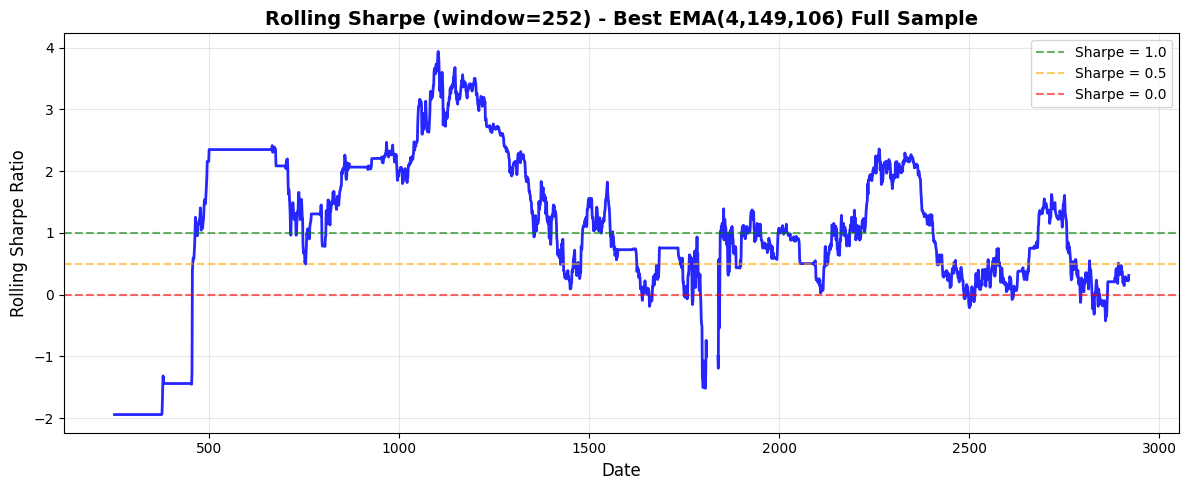

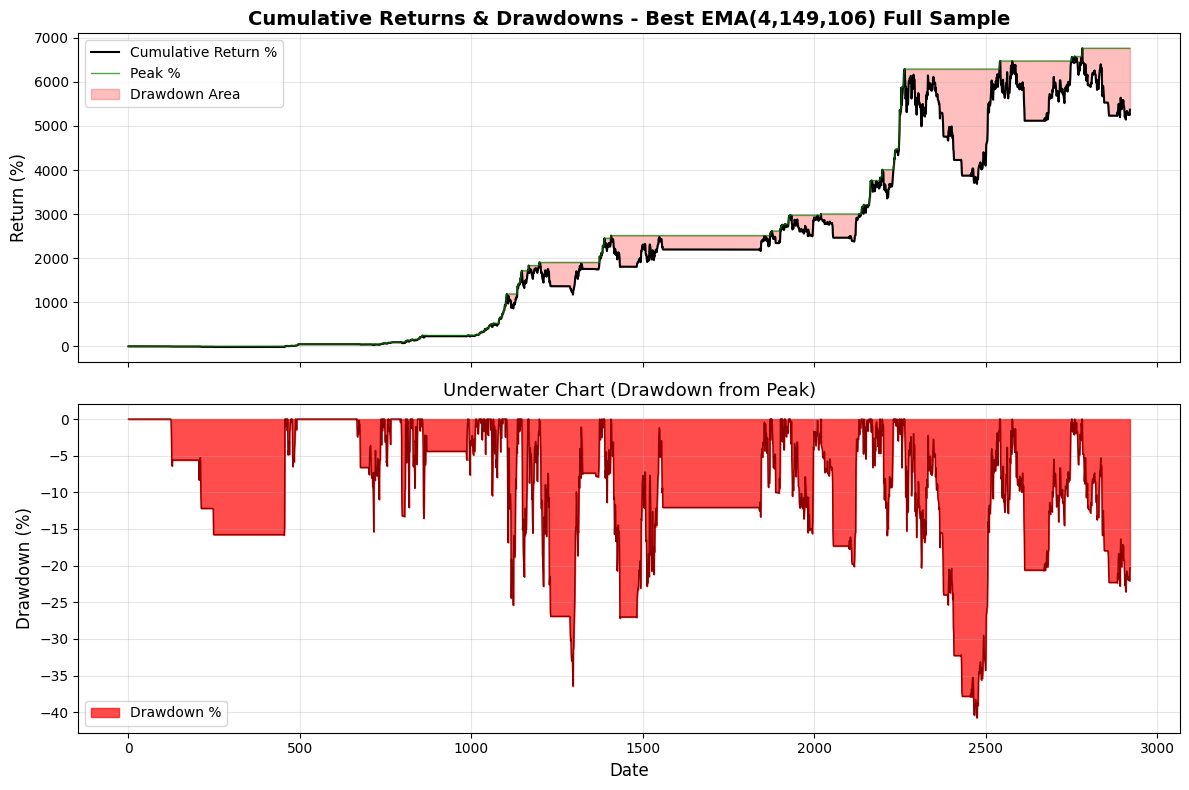

✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA(4,149,106)


In [18]:
# FULL-SAMPLE ROLLING SHARPE + DRAWDOWNS - BEST STRATEGY

if results_df.empty:
    print("No results to visualize.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Build full-sample Triple EMA signals
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma
    
    # Triple EMA crossover signals (RAW)
    entries_1 = ema1_full.vbt.crossed_above(ema2_full).reindex(close.index).fillna(False)
    entries_2 = ema1_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    entries_3 = ema2_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    entries_raw = entries_1 | entries_2 | entries_3
    
    exits_1 = ema1_full.vbt.crossed_below(ema2_full).reindex(close.index).fillna(False)
    exits_2 = ema1_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    exits_3 = ema2_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    exits_raw = exits_1 | exits_2 | exits_3
    
    # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
    entries_full = entries_raw.shift(1).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_raw.shift(1).fillna(False).to_numpy(dtype=bool)

    price_full = close.to_numpy(dtype=float)

    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    # Compute returns
    ret = pf_full.returns()

    # 1) Rolling Sharpe (252-day window)
    rolling_window = max(20, min(252, max(1, len(ret) // 4)))
    if len(ret) > rolling_window:
        rolling_sharpe = ret.rolling(window=rolling_window).apply(
            lambda x: (x.mean() * 252) / (x.std() * np.sqrt(252)) if x.std() and x.std() != 0 else np.nan,
            raw=False
        )

        plt.figure(figsize=(12, 5))
        plt.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='blue', alpha=0.85)
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.6, label='Sharpe = 1.0')
        plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, label='Sharpe = 0.5')
        plt.axhline(y=0.0, color='red', linestyle='--', alpha=0.6, label='Sharpe = 0.0')
        plt.title(f'Rolling Sharpe (window={rolling_window}) - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Rolling Sharpe Ratio', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough data for rolling Sharpe calculation.")

    # 2) Drawdowns (underwater)
    eq = (1 + ret).cumprod()
    peak = eq.cummax()
    dd = (eq - peak) / peak

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax1.plot(eq.index, (eq - 1) * 100, color='black', linewidth=1.5, label='Cumulative Return %')
    ax1.plot(peak.index, (peak - 1) * 100, color='green', linewidth=1.0, alpha=0.7, label='Peak %')
    ax1.fill_between(eq.index, (eq - 1) * 100, (peak - 1) * 100, color='red', alpha=0.25, label='Drawdown Area')
    ax1.set_title(f'Cumulative Returns & Drawdowns - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.fill_between(dd.index, dd * 100, 0, color='red', alpha=0.7, label='Drawdown %')
    ax2.plot(dd.index, dd * 100, color='darkred', linewidth=1)
    ax2.set_title('Underwater Chart (Drawdown from Peak)', fontsize=13)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    
    print(f"✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA({ema1},{ema2},{ema3})")

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/409243117.py:22: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/409243117.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



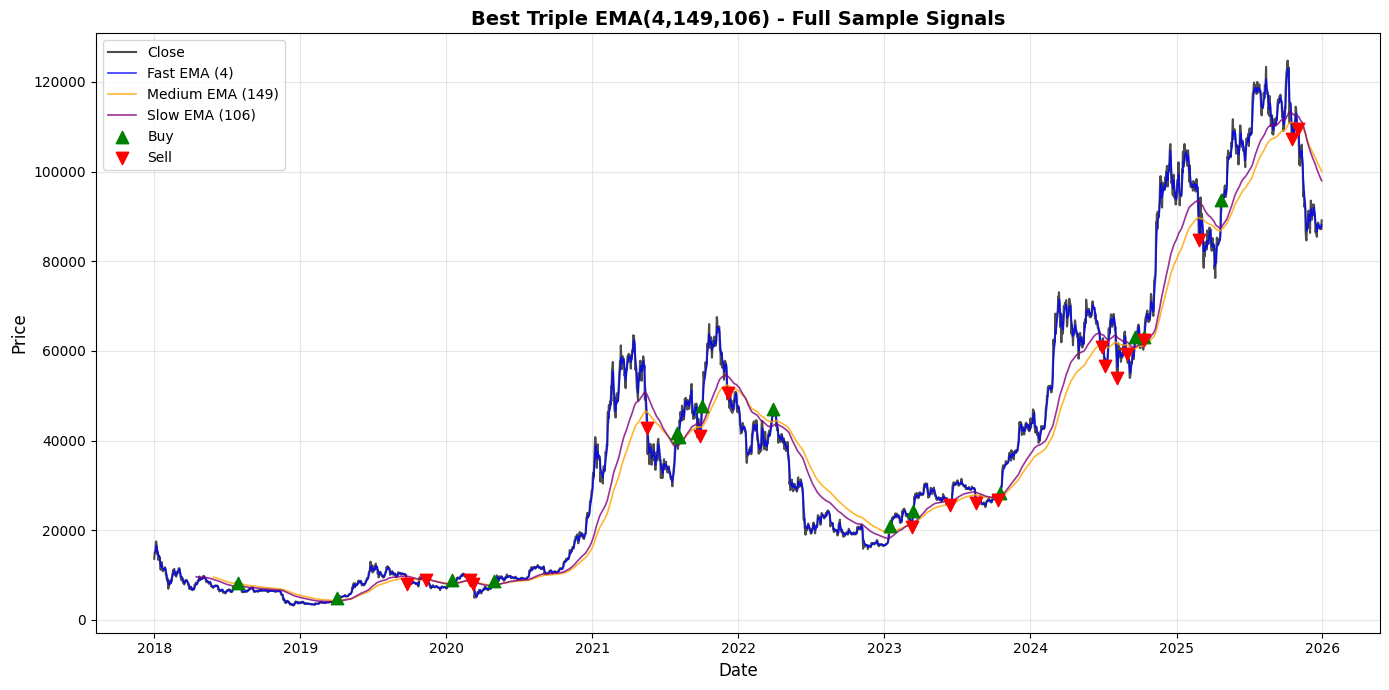

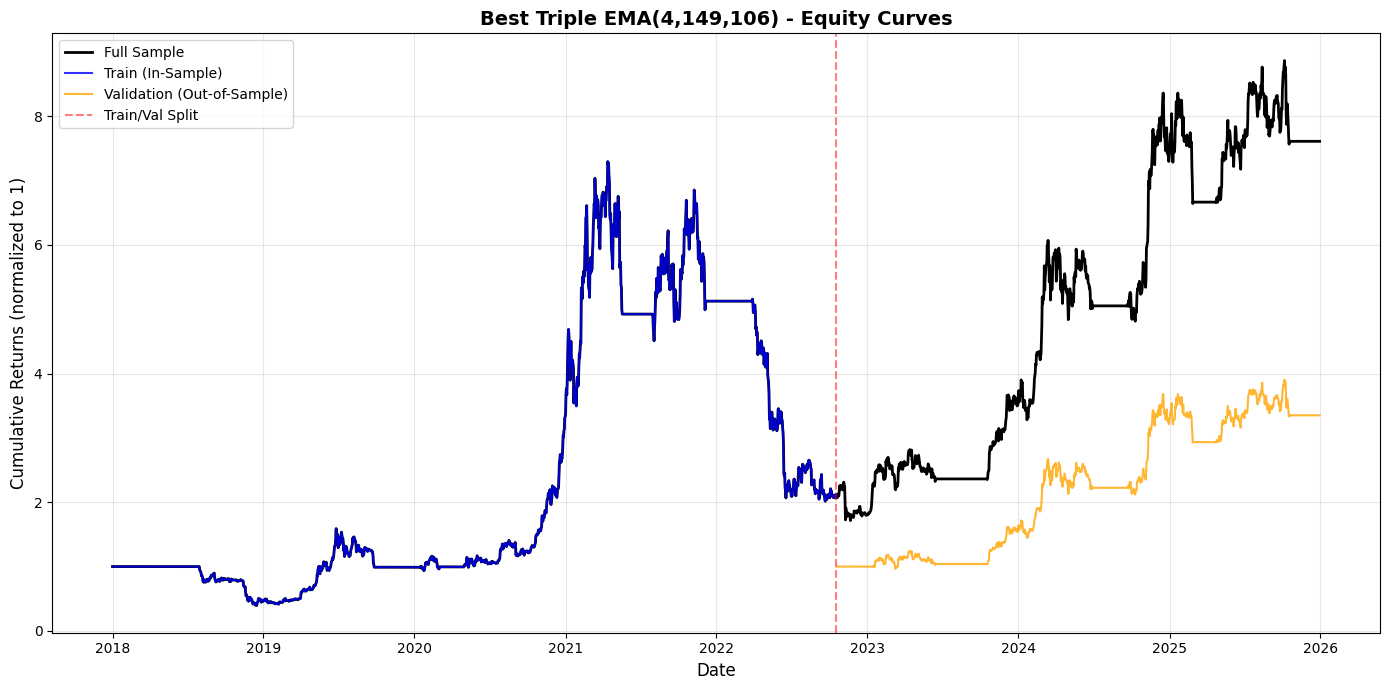

Visualizations complete for best strategy: EMA(4,149,106)


In [19]:
# STEP 5C: VISUALS ONLY (Signals + Equity Curves) - BEST STRATEGY

if results_df.empty:
    print("No results to visualize.")
else:
    # Get BEST strategy (highest Sharpe ratio)
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Build full sample EMAs and signals for Triple EMA
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma
    
    # Triple EMA crossover signals (RAW)
    entries_raw = ((ema1_full.vbt.crossed_above(ema2_full) & (ema1_full > ema3_full)) |
                   (ema2_full.vbt.crossed_above(ema3_full) & (ema1_full > ema2_full)))
    exits_raw = ((ema1_full.vbt.crossed_below(ema2_full) & (ema1_full < ema3_full)) |
                 (ema2_full.vbt.crossed_below(ema3_full) & (ema1_full < ema2_full)))
    
    # ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
    entries_full = entries_raw.shift(1).fillna(False).reindex(close.index).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_raw.shift(1).fillna(False).reindex(close.index).fillna(False).to_numpy(dtype=bool)

    # 1) Price + Triple EMAs + signals (full sample)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, close.values, label='Close', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(close.index, ema1_full.values, label=f'Fast EMA ({ema1})', color='blue', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema2_full.values, label=f'Medium EMA ({ema2})', color='orange', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema3_full.values, label=f'Slow EMA ({ema3})', color='purple', alpha=0.8, linewidth=1.2)

    buy_idx = close.index[entries_full]
    sell_idx = close.index[exits_full]
    ax.scatter(buy_idx, close.reindex(buy_idx).values, marker='^', color='green', s=80, label='Buy', zorder=5)
    ax.scatter(sell_idx, close.reindex(sell_idx).values, marker='v', color='red', s=80, label='Sell', zorder=5)

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Full Sample Signals', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # 2) Equity curves: train / val / full
    price_full = close.to_numpy(dtype=float)
    entries_train = entries_full[:split_idx]
    exits_train = exits_full[:split_idx]
    entries_val = entries_full[split_idx:]
    exits_val = exits_full[split_idx:]

    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_train = vbt.Portfolio.from_signals(
        close=train_close.to_numpy(dtype=float),
        entries=entries_train,
        exits=exits_train,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_val2 = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    eq_full = (1 + pf_full.returns()).cumprod()
    eq_train = (1 + pf_train.returns()).cumprod()
    eq_val = (1 + pf_val2.returns()).cumprod()

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, eq_full.values, label='Full Sample', color='black', linewidth=2)
    ax.plot(train_close.index, eq_train.values, label='Train (In-Sample)', color='blue', linewidth=1.5, alpha=0.8)
    ax.plot(val_close.index, eq_val.values, label='Validation (Out-of-Sample)', color='orange', linewidth=1.5, alpha=0.8)
    
    # Add vertical line to show train/val split
    ax.axvline(x=train_close.index[-1], color='red', linestyle='--', alpha=0.5, label='Train/Val Split')

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Equity Curves', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Returns (normalized to 1)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(f"Visualizations complete for best strategy: EMA({ema1},{ema2},{ema3})")

Total trades plotted: 29
Win Rate: 48.3% (14W / 15L)
Avg Win: 55.53% | Avg Loss: -5.29%
Max Win: 344.17% | Max Loss: -10.91%


/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/383210688.py:53: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_16081/383210688.py:54: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



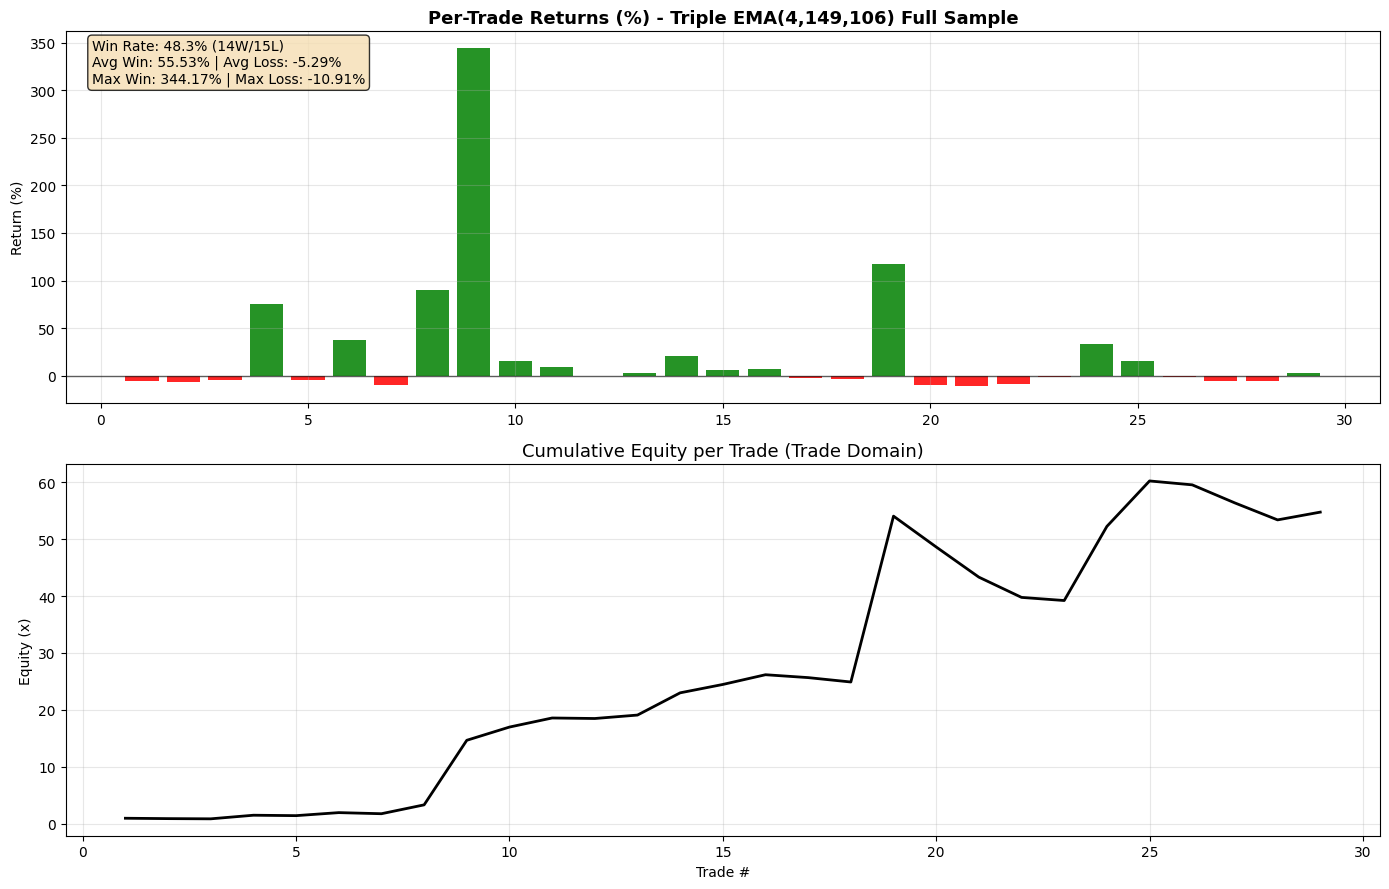

In [20]:
# FULL-SAMPLE TRADE-BY-TRADE RETURNS (BAR) + CUMULATIVE PER-TRADE EQUITY — ALL TRADESbt

if 'FREQ' not in globals():
    FREQ = "1D"

# Resolve full close series
if 'close' in globals() and hasattr(close, 'index'):
    full_close = close.astype(float)
else:
    if isinstance(stock_data.columns, pd.MultiIndex):
        if ('Close', TICKER) in stock_data.columns:
            full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
        else:
            found = None
            for col in stock_data.columns:
                if isinstance(col, tuple) and ('Close' in col):
                    found = col; break
            if found is None:
                for col in stock_data.columns:
                    if 'Close' in str(col):
                        found = col; break
            if found is None:
                raise KeyError("Could not find a 'Close' column for full-sample trade plot.")
            full_close = stock_data[found].astype(float).rename(TICKER)
    else:
        full_close = stock_data['Close'].astype(float).rename(TICKER)

# Best params
if 'results_df' not in globals() or results_df.empty:
    raise ValueError("results_df is empty or missing. Run the grid search first.")
best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

# Indicators
ema1_full = vbt.MA.run(full_close, ema1, ewm=True)
ema2_full = vbt.MA.run(full_close, ema2, ewm=True)
ema3_full = vbt.MA.run(full_close, ema3, ewm=True)

# Signals (MATCH GRID SEARCH LOGIC - simple OR, no extra conditions)
entries_raw = (
    ema1_full.ma_crossed_above(ema2_full.ma) |
    ema1_full.ma_crossed_above(ema3_full.ma) |
    ema2_full.ma_crossed_above(ema3_full.ma)
)
exits_raw = (
    ema1_full.ma_crossed_below(ema2_full.ma) |
    ema1_full.ma_crossed_below(ema3_full.ma) |
    ema2_full.ma_crossed_below(ema3_full.ma)
)

# ⚠️ FIX LOOKAHEAD BIAS: Shift signals by 1 bar
# Convert to plain arrays AND shift
entries_shifted = pd.Series(np.asarray(entries_raw).ravel(), index=full_close.index, dtype=bool).shift(1).fillna(False)
exits_shifted = pd.Series(np.asarray(exits_raw).ravel(), index=full_close.index, dtype=bool).shift(1).fillna(False)

entries_full = pd.Series(np.asarray(entries_shifted).ravel(), index=full_close.index, dtype=bool)
exits_full = pd.Series(np.asarray(exits_shifted).ravel(), index=full_close.index, dtype=bool)

# Backtest
pf_full = vbt.Portfolio.from_signals(
    close=full_close.to_numpy(dtype=float),
    entries=entries_full,
    exits=exits_full,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq=FREQ
)

# Trade-by-trade returns (ALL trades)
trades = pf_full.trades
trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.asarray(trades.returns)
trade_returns = np.asarray(trade_returns).ravel()  # ensure 1D

if trade_returns.size == 0:
    print("No trades to plot.")
else:
    # Calculate statistics
    winning_trades = trade_returns[trade_returns > 0]
    losing_trades = trade_returns[trade_returns < 0]
    
    total_trades = len(trade_returns)
    win_count = len(winning_trades)
    loss_count = len(losing_trades)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0
    
    avg_win_pct = (winning_trades.mean() * 100) if len(winning_trades) > 0 else 0
    avg_loss_pct = (losing_trades.mean() * 100) if len(losing_trades) > 0 else 0
    max_win_pct = (winning_trades.max() * 100) if len(winning_trades) > 0 else 0
    max_loss_pct = (losing_trades.min() * 100) if len(losing_trades) > 0 else 0
    
    print(f"Total trades plotted: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)")
    print(f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%")
    print(f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%")
    
    equity_per_trade = np.cumprod(1.0 + trade_returns)

    fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

    # Per-trade returns (%), all trades
    x = np.arange(1, trade_returns.size + 1)
    colors = np.where(trade_returns >= 0, 'green', 'red')
    axes[0].bar(x, trade_returns * 100.0, color=colors, alpha=0.85, width=0.8)
    axes[0].axhline(0, color='black', linewidth=1, alpha=0.6)
    
    # Add statistics text box on the chart
    stats_text = (
        f'Win Rate: {win_rate:.1f}% ({win_count}W/{loss_count}L)\n'
        f'Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%\n'
        f'Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%'
    )
    axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[0].set_title(f'Per-Trade Returns (%) - Triple EMA({ema1},{ema2},{ema3}) Full Sample', 
                     fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Return (%)')
    axes[0].grid(True, alpha=0.3)

    # Cumulative equity per trade
    axes[1].plot(x, equity_per_trade, color='black', linewidth=2)
    axes[1].set_title('Cumulative Equity per Trade (Trade Domain)', fontsize=13)
    axes[1].set_xlabel('Trade #')
    axes[1].set_ylabel('Equity (x)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


🔬 PARAMETER SENSITIVITY ANALYSIS - Base: EMA(4,152,106)
IS Sharpe: 1.751 | OOS Sharpe: 0.897

🔄 Testing 80 parameter variations...


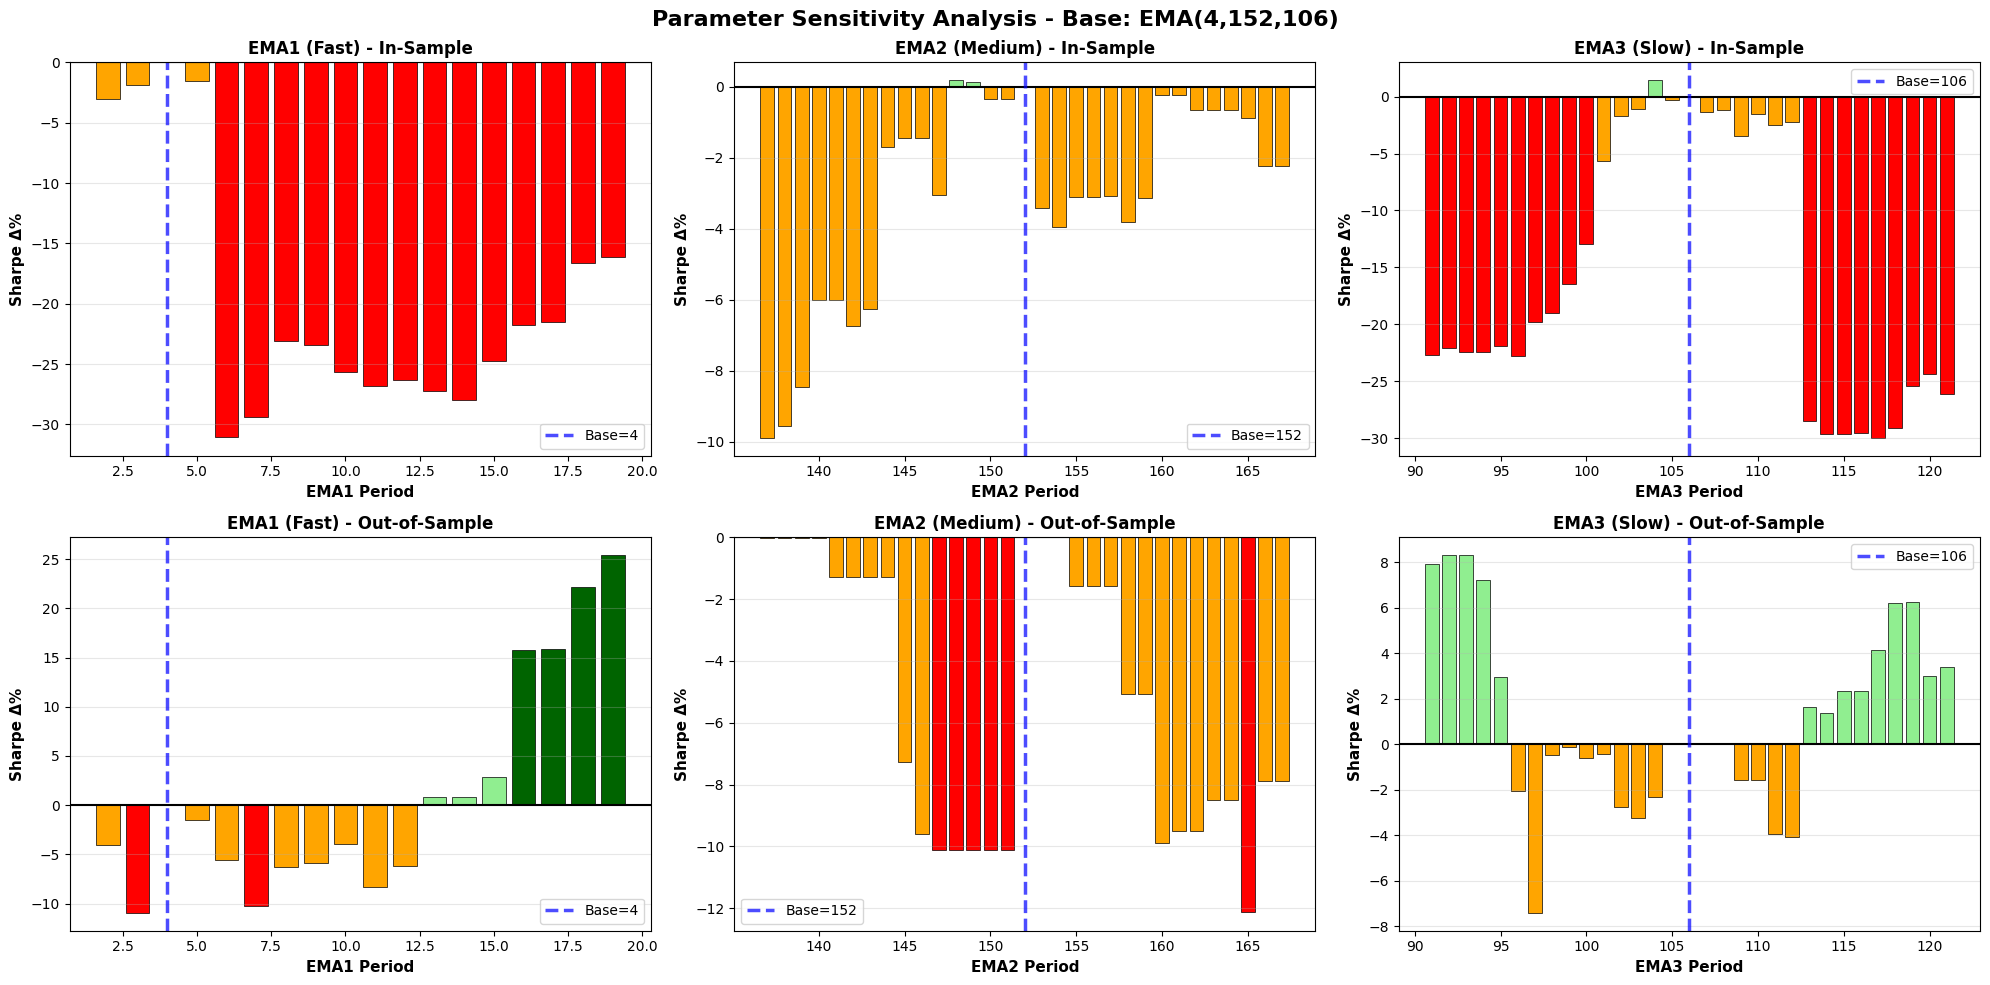


📋 SENSITIVITY SUMMARY
Parameter      IS Range IS Max Δ%     OOS Range OOS Max Δ% Sensitivity
     EMA1 1.208 - 1.751    -31.0% 0.799 - 1.125     -10.9%       ✅ LOW
     EMA2 1.578 - 1.755     -9.9% 0.788 - 0.897     -12.1%       ✅ LOW
     EMA3 1.226 - 1.777    -30.0% 0.831 - 0.972      -7.4%       ✅ LOW

✅ Analysis Complete! Green = Robust, Red = Fragile


In [21]:
# COMPACT PARAMETER SENSITIVITY ANALYSIS - HEATMAPS ONLY

if results_df.empty:
    print("No results available for sensitivity analysis.")
else:
    # Use BEST OOS strategy (from previous cells)
    if 'BEST_EMA1' in globals():
        ema1_base, ema2_base, ema3_base = BEST_EMA1, BEST_EMA2, BEST_EMA3
        base_is_sharpe = BEST_IS_SHARPE
        base_oos_sharpe = BEST_OOS_SHARPE
        print(f"🔬 PARAMETER SENSITIVITY ANALYSIS - Base: EMA({ema1_base},{ema2_base},{ema3_base})")
        print(f"IS Sharpe: {base_is_sharpe:.3f} | OOS Sharpe: {base_oos_sharpe:.3f}")
    else:
        best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
        ema1_base, ema2_base, ema3_base = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])
        base_is_sharpe = float(best['sharpe_ratio'])
        base_oos_sharpe = np.nan
        print(f"🔬 PARAMETER SENSITIVITY ANALYSIS - Base: EMA({ema1_base},{ema2_base},{ema3_base})")
        print(f"IS Sharpe: {base_is_sharpe:.3f}")

    # Create sensitivity ranges (±15 around each parameter)
    ema1_range = sorted(list(set(range(max(2, ema1_base - 15), ema1_base + 16))))
    ema2_range = sorted(list(set(range(max(3, ema2_base - 15), ema2_base + 16))))
    ema3_range = sorted(list(set(range(max(4, ema3_base - 15), ema3_base + 16))))
    
    combos_ema1 = [(e1, ema2_base, ema3_base) for e1 in ema1_range]
    combos_ema2 = [(ema1_base, e2, ema3_base) for e2 in ema2_range]
    combos_ema3 = [(ema1_base, ema2_base, e3) for e3 in ema3_range]
    all_combos = combos_ema1 + combos_ema2 + combos_ema3

    def eval_combo_both(e1: int, e2: int, e3: int) -> dict:
        """Evaluate on both in-sample and out-of-sample"""
        # IN-SAMPLE
        fma_is = pd.Series(vbt.MA.run(train_close, e1, ewm=True).ma.values.flatten(), index=train_close.index)
        mma_is = pd.Series(vbt.MA.run(train_close, e2, ewm=True).ma.values.flatten(), index=train_close.index)
        sma_is = pd.Series(vbt.MA.run(train_close, e3, ewm=True).ma.values.flatten(), index=train_close.index)
        
        e_raw_is = (fma_is.vbt.crossed_above(mma_is) | fma_is.vbt.crossed_above(sma_is) | mma_is.vbt.crossed_above(sma_is))
        x_raw_is = (fma_is.vbt.crossed_below(mma_is) | fma_is.vbt.crossed_below(sma_is) | mma_is.vbt.crossed_below(sma_is))
        
        e_shifted_is = e_raw_is.shift(1)
        e_is = pd.Series(np.where(e_shifted_is.isna(), False, e_shifted_is), index=train_close.index, dtype=bool)
        x_shifted_is = x_raw_is.shift(1)
        x_is = pd.Series(np.where(x_shifted_is.isna(), False, x_shifted_is), index=train_close.index, dtype=bool)
        
        pf_is = vbt.Portfolio.from_signals(close=train_close, entries=e_is, exits=x_is, 
                                          init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D')
        
        # OUT-OF-SAMPLE
        fma_oos = pd.Series(vbt.MA.run(val_close, e1, ewm=True).ma.values.flatten(), index=val_close.index)
        mma_oos = pd.Series(vbt.MA.run(val_close, e2, ewm=True).ma.values.flatten(), index=val_close.index)
        sma_oos = pd.Series(vbt.MA.run(val_close, e3, ewm=True).ma.values.flatten(), index=val_close.index)
        
        e_raw_oos = (fma_oos.vbt.crossed_above(mma_oos) | fma_oos.vbt.crossed_above(sma_oos) | mma_oos.vbt.crossed_above(sma_oos))
        x_raw_oos = (fma_oos.vbt.crossed_below(mma_oos) | fma_oos.vbt.crossed_below(sma_oos) | mma_oos.vbt.crossed_below(sma_oos))
        
        e_shifted_oos = e_raw_oos.shift(1)
        e_oos = pd.Series(np.where(e_shifted_oos.isna(), False, e_shifted_oos), index=val_close.index, dtype=bool)
        x_shifted_oos = x_raw_oos.shift(1)
        x_oos = pd.Series(np.where(x_shifted_oos.isna(), False, x_shifted_oos), index=val_close.index, dtype=bool)
        
        pf_oos = vbt.Portfolio.from_signals(close=val_close, entries=e_oos, exits=x_oos,
                                           init_cash=100_000, fees=0.0005, slippage=0.0005, freq='D')
        
        return {
            'ema1': e1, 'ema2': e2, 'ema3': e3,
            'is_sharpe': float(pf_is.sharpe_ratio(freq='D')),
            'is_return': float(pf_is.total_return()),
            'is_maxdd': float(pf_is.max_drawdown()),
            'oos_sharpe': float(pf_oos.sharpe_ratio(freq='D')),
            'oos_return': float(pf_oos.total_return()),
            'oos_maxdd': float(pf_oos.max_drawdown()),
            'oos_trades': len(pf_oos.trades)
        }

    print(f"\n🔄 Testing {len(all_combos)} parameter variations...")
    
    rows = []
    for combo in all_combos:
        try:
            rows.append(eval_combo_both(*combo))
        except Exception:
            pass

    if not rows:
        print("❌ No sensitivity results computed.")
    else:
        sens_df = pd.DataFrame(rows)
        
        # Split by parameter variation type (fix boolean indexing)
        ema1_variations = sens_df[(sens_df['ema2'] == ema2_base) & (sens_df['ema3'] == ema3_base)].copy().sort_values('ema1')
        ema2_variations = sens_df[(sens_df['ema1'] == ema1_base) & (sens_df['ema3'] == ema3_base)].copy().sort_values('ema2')
        ema3_variations = sens_df[(sens_df['ema1'] == ema1_base) & (sens_df['ema2'] == ema2_base)].copy().sort_values('ema3')
        
        # Calculate degradations
        ema1_variations['is_sharpe_delta'] = ((ema1_variations['is_sharpe'] - base_is_sharpe) / abs(base_is_sharpe) * 100)
        ema2_variations['is_sharpe_delta'] = ((ema2_variations['is_sharpe'] - base_is_sharpe) / abs(base_is_sharpe) * 100)
        ema3_variations['is_sharpe_delta'] = ((ema3_variations['is_sharpe'] - base_is_sharpe) / abs(base_is_sharpe) * 100)
        
        if not np.isnan(base_oos_sharpe):
            ema1_variations['oos_sharpe_delta'] = ((ema1_variations['oos_sharpe'] - base_oos_sharpe) / abs(base_oos_sharpe) * 100)
            ema2_variations['oos_sharpe_delta'] = ((ema2_variations['oos_sharpe'] - base_oos_sharpe) / abs(base_oos_sharpe) * 100)
            ema3_variations['oos_sharpe_delta'] = ((ema3_variations['oos_sharpe'] - base_oos_sharpe) / abs(base_oos_sharpe) * 100)
        
        # CREATE BAR CHARTS - MUCH CLEANER FOR 1D SENSITIVITY
        fig, axes = plt.subplots(2, 3, figsize=(20, 10))
        fig.suptitle(f'Parameter Sensitivity Analysis - Base: EMA({ema1_base},{ema2_base},{ema3_base})', 
                     fontsize=16, fontweight='bold')
        
        # IN-SAMPLE BAR CHARTS
        # EMA1 IS
        colors1_is = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                      for x in ema1_variations['is_sharpe_delta']]
        bars1 = axes[0, 0].bar(ema1_variations['ema1'], ema1_variations['is_sharpe_delta'], color=colors1_is, edgecolor='black', linewidth=0.5)
        axes[0, 0].axhline(0, color='black', linewidth=1.5)
        axes[0, 0].axvline(ema1_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema1_base}')
        axes[0, 0].set_xlabel('EMA1 Period', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('EMA1 (Fast) - In-Sample', fontsize=12, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].legend(fontsize=10)
        
        # EMA2 IS
        colors2_is = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                      for x in ema2_variations['is_sharpe_delta']]
        bars2 = axes[0, 1].bar(ema2_variations['ema2'], ema2_variations['is_sharpe_delta'], color=colors2_is, edgecolor='black', linewidth=0.5)
        axes[0, 1].axhline(0, color='black', linewidth=1.5)
        axes[0, 1].axvline(ema2_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema2_base}')
        axes[0, 1].set_xlabel('EMA2 Period', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('EMA2 (Medium) - In-Sample', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
        axes[0, 1].legend(fontsize=10)
        
        # EMA3 IS
        colors3_is = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                      for x in ema3_variations['is_sharpe_delta']]
        bars3 = axes[0, 2].bar(ema3_variations['ema3'], ema3_variations['is_sharpe_delta'], color=colors3_is, edgecolor='black', linewidth=0.5)
        axes[0, 2].axhline(0, color='black', linewidth=1.5)
        axes[0, 2].axvline(ema3_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema3_base}')
        axes[0, 2].set_xlabel('EMA3 Period', fontsize=11, fontweight='bold')
        axes[0, 2].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
        axes[0, 2].set_title('EMA3 (Slow) - In-Sample', fontsize=12, fontweight='bold')
        axes[0, 2].grid(axis='y', alpha=0.3)
        axes[0, 2].legend(fontsize=10)
        
        # OUT-OF-SAMPLE BAR CHARTS
        if not np.isnan(base_oos_sharpe):
            # EMA1 OOS
            colors1_oos = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                          for x in ema1_variations['oos_sharpe_delta']]
            bars4 = axes[1, 0].bar(ema1_variations['ema1'], ema1_variations['oos_sharpe_delta'], color=colors1_oos, edgecolor='black', linewidth=0.5)
            axes[1, 0].axhline(0, color='black', linewidth=1.5)
            axes[1, 0].axvline(ema1_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema1_base}')
            axes[1, 0].set_xlabel('EMA1 Period', fontsize=11, fontweight='bold')
            axes[1, 0].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
            axes[1, 0].set_title('EMA1 (Fast) - Out-of-Sample', fontsize=12, fontweight='bold')
            axes[1, 0].grid(axis='y', alpha=0.3)
            axes[1, 0].legend(fontsize=10)
            
            # EMA2 OOS
            colors2_oos = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                          for x in ema2_variations['oos_sharpe_delta']]
            bars5 = axes[1, 1].bar(ema2_variations['ema2'], ema2_variations['oos_sharpe_delta'], color=colors2_oos, edgecolor='black', linewidth=0.5)
            axes[1, 1].axhline(0, color='black', linewidth=1.5)
            axes[1, 1].axvline(ema2_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema2_base}')
            axes[1, 1].set_xlabel('EMA2 Period', fontsize=11, fontweight='bold')
            axes[1, 1].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
            axes[1, 1].set_title('EMA2 (Medium) - Out-of-Sample', fontsize=12, fontweight='bold')
            axes[1, 1].grid(axis='y', alpha=0.3)
            axes[1, 1].legend(fontsize=10)
            
            # EMA3 OOS
            colors3_oos = ['red' if x < -10 else 'orange' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                          for x in ema3_variations['oos_sharpe_delta']]
            bars6 = axes[1, 2].bar(ema3_variations['ema3'], ema3_variations['oos_sharpe_delta'], color=colors3_oos, edgecolor='black', linewidth=0.5)
            axes[1, 2].axhline(0, color='black', linewidth=1.5)
            axes[1, 2].axvline(ema3_base, color='blue', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Base={ema3_base}')
            axes[1, 2].set_xlabel('EMA3 Period', fontsize=11, fontweight='bold')
            axes[1, 2].set_ylabel('Sharpe Δ%', fontsize=11, fontweight='bold')
            axes[1, 2].set_title('EMA3 (Slow) - Out-of-Sample', fontsize=12, fontweight='bold')
            axes[1, 2].grid(axis='y', alpha=0.3)
            axes[1, 2].legend(fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # COMPACT SUMMARY TABLE
        print("\n📋 SENSITIVITY SUMMARY")
        print("=" * 80)
        
        summary_data = []
        for param_name, variations, param_col in [('EMA1', ema1_variations, 'ema1'), 
                                                   ('EMA2', ema2_variations, 'ema2'), 
                                                   ('EMA3', ema3_variations, 'ema3')]:
            summary_data.append({
                'Parameter': param_name,
                'IS Range': f"{variations['is_sharpe'].min():.3f} - {variations['is_sharpe'].max():.3f}",
                'IS Max Δ%': f"{variations['is_sharpe_delta'].min():.1f}%",
                'OOS Range': f"{variations['oos_sharpe'].min():.3f} - {variations['oos_sharpe'].max():.3f}" if not np.isnan(base_oos_sharpe) else 'N/A',
                'OOS Max Δ%': f"{variations['oos_sharpe_delta'].min():.1f}%" if not np.isnan(base_oos_sharpe) and 'oos_sharpe_delta' in variations else 'N/A',
                'Sensitivity': '⚠️ HIGH' if abs(variations['is_sharpe_delta'].min()) > 40 else '✅ LOW'
            })
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        
        print("\n✅ Analysis Complete! Green = Robust, Red = Fragile")